<a href="https://colab.research.google.com/github/briandepasquale/transformer/blob/main/Transformer_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

In [2]:
# ======================================================
# 1. Device Setup
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:

# ======================================================
# 2. Synthetic Data Generator (White Noise with Fixed Lag)
# ======================================================
def generate_batch(batch_size, seq_len, tau, obs_noise=0.05):
    x = torch.randn(batch_size, seq_len)
    y = torch.roll(x, shifts=tau, dims=1)
    y[:, :tau] = 0.0
    y = y + obs_noise * torch.randn_like(y)
    return x.unsqueeze(-1), y.unsqueeze(-1)

In [4]:
# ======================================================
# 2. Synthetic Data Generator (White Noise with Variable τ)
# ======================================================
def generate_batch_var(batch_size, seq_len, tau_min=0, tau_max=10, obs_noise=0.0):
    """
    Each example in the batch has white noise input x, and target y = x shifted by a random τ.
    """
    x_batch = []
    y_batch = []
    tau_list = []

    for _ in range(batch_size):
        x = torch.randn(seq_len)
        tau = torch.randint(tau_min, tau_max + 1, (1,)).item()
        y = torch.roll(x, shifts=tau, dims=0)
        y[:tau] = 0.0
        if obs_noise > 0:
            x = x + obs_noise * torch.randn_like(x)
            y = y + obs_noise * torch.randn_like(y)
        x_batch.append(x)
        y_batch.append(y)
        tau_list.append(tau)

    x_batch = torch.stack(x_batch).unsqueeze(-1)  # (B, T, 1)
    y_batch = torch.stack(y_batch).unsqueeze(-1)
    tau_list = torch.tensor(tau_list)
    return x_batch, y_batch, tau_list

In [5]:
# ======================================================
# 2. Synthetic Data Generator (Sine Wave + Optional Noise)
# ======================================================
def generate_batch_sin(batch_size, seq_len, tau, freq=2.0, obs_noise=0.05):
    t = torch.linspace(0, 2 * math.pi, seq_len)
    x = torch.sin(freq * t).unsqueeze(0).repeat(batch_size, 1)
    y = torch.roll(x, shifts=tau, dims=1)
    y[:, :tau] = 0.0
    if obs_noise > 0:
        x = x + obs_noise * torch.randn_like(x)
        y = y + obs_noise * torch.randn_like(y)
    return x.unsqueeze(-1), y.unsqueeze(-1)

In [6]:
def generate_periodic_batch(
    batch_size=64,
    seq_len=1000,
    min_lag=5,
    max_lag=25,
    n_freqs=10,
    noise_std=0.05,
    device='cpu'
):
    """
    Generate a batch of periodic signals with variable lags and additive noise,
    fully in PyTorch.

    Returns:
        x: (B, T, 1)  input sequences
        y: (B, T, 1)  target sequences (lagged)
        lags: (B,)    integer lag for each example
    """

    # Time axis [0, 2π], shape (T,)
    t = torch.linspace(0, 2 * torch.pi, seq_len, device=device)

    # Random frequencies (B, n_freqs)
    freqs = torch.rand(batch_size, n_freqs, device=device) * 10 + 1   # [1,11]

    # Random phases (B, n_freqs)
    phases = torch.rand(batch_size, n_freqs, device=device) * 2 * torch.pi

    # Expand time axis for broadcasting: (B, n_freqs, T)
    t_expanded = t.unsqueeze(0).unsqueeze(0)  # (1,1,T)
    t_expanded = t_expanded.expand(batch_size, n_freqs, seq_len)

    freqs_expanded = freqs.unsqueeze(-1)     # (B, n_freqs, 1)
    phases_expanded = phases.unsqueeze(-1)   # (B, n_freqs, 1)

    # Periodic signal: sum over n_freqs
    signal_components = torch.sin(freqs_expanded * t_expanded + phases_expanded)
    signal = signal_components.sum(dim=1)  # (B, T)

    # Add Gaussian noise
    if noise_std > 0:
        signal += torch.randn_like(signal) * noise_std

    # Sample random lags per example (B,)
    lags = torch.randint(low=min_lag, high=max_lag+1, size=(batch_size,), device=device)

    # Create y by rolling each sequence individually
    y = torch.zeros_like(signal)
    for i, lag in enumerate(lags):
        y[i] = torch.roll(signal[i], shifts=int(lag.item()))
        y[i, :lag] = 0.0  # zero out wrapped section to avoid leakage

    # Add channel dimension
    x = signal.unsqueeze(-1)  # (B, T, 1)
    y = y.unsqueeze(-1)       # (B, T, 1)

    y = torch.tanh(y)
    # ✅ Add noise to the output targets to make the task harder
    y = y + torch.randn_like(y) * noise_std

    return x, y, lags

In [7]:
def generate_periodic_batch(
    batch_size=64,
    seq_len=1000,
    small_lag=20,
    large_lag=220,
    n_freqs=4,
    noise_std=0.05,
    device='cpu'
):
    """
    Generate a batch of periodic signals with *two possible lags* (small or large)
    and additive noise, fully in PyTorch.

    Returns:
        x: (B, T, 1)  input sequences
        y: (B, T, 1)  target sequences (lagged)
        lags: (B,)    integer lag for each example
    """

    # Time axis [0, 2π], shape (T,)
    t = torch.linspace(0, 2 * torch.pi, seq_len, device=device)

    # Random frequencies (B, n_freqs)
    freqs = torch.rand(batch_size, n_freqs, device=device) * 10 + 1   # [1,11]

    # Random phases (B, n_freqs)
    phases = torch.rand(batch_size, n_freqs, device=device) * 2 * torch.pi

    # Expand time axis for broadcasting: (B, n_freqs, T)
    t_expanded = t.unsqueeze(0).unsqueeze(0)  # (1,1,T)
    t_expanded = t_expanded.expand(batch_size, n_freqs, seq_len)

    freqs_expanded = freqs.unsqueeze(-1)     # (B, n_freqs, 1)
    phases_expanded = phases.unsqueeze(-1)   # (B, n_freqs, 1)

    # Periodic signal: sum over n_freqs
    signal_components = torch.sin(freqs_expanded * t_expanded + phases_expanded)
    signal = signal_components.sum(dim=1)  # (B, T)

    # Add Gaussian noise
    if noise_std > 0:
        signal += torch.randn_like(signal) * noise_std

    # 🔥 Sample lags: each example randomly gets either small_lag or large_lag
    choices = torch.tensor([small_lag, large_lag], device=device)
    lags = choices[torch.randint(0, 2, (batch_size,), device=device)]

    # Create y by rolling each sequence individually
    y = torch.zeros_like(signal)
    for i, lag in enumerate(lags):
        y[i] = torch.roll(signal[i], shifts=int(lag.item()))
        y[i, :lag] = 0.0  # zero out wrapped section to avoid leakage

    # Add channel dimension
    x = signal.unsqueeze(-1)  # (B, T, 1)
    y = y.unsqueeze(-1)       # (B, T, 1)

    # Optional nonlinearity
    y = torch.tanh(y)

    # ✅ Add noise to the outputs
    y = y + torch.randn_like(y) * noise_std

    return x, y, lags

In [8]:
# ======================================================
# 3. Positional Encoding
# ======================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, T, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [9]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        # Input/output projections
        self.in_proj = nn.Linear(1, d_model)
        self.out_proj = nn.Linear(d_model, 1)

        # Positional encoding
        self.pos_enc = PositionalEncoding(d_model)

        # Encoder and decoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

    def forward(self, src, tgt):
        """
        src: (B, T_src, 1) input sequence
        tgt: (B, T_tgt, 1) target sequence (or zeros if teacher forcing is not used)
        """

        # Project to model dimension
        src = self.in_proj(src)
        tgt = self.in_proj(tgt)

        # Add positional encodings
        src = self.pos_enc(src)
        tgt = self.pos_enc(tgt)

        # Encode/decode
        memory = self.encoder(src)
        out = self.decoder(tgt, memory)

        # Project back to 1D
        return self.out_proj(out)

In [10]:
model = Seq2SeqTransformer(
    d_model=64,
    nhead=1,
    num_layers=2,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

/projectnb/depaqlab/bddepasq/transformer/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [11]:
#seq_len = 50
#tau = 5
#batch_size = 64
n_batches = 3000

In [12]:
loss_history = []
print("Training...")

for step in range(n_batches):
    # Generate training batch
    x, y, _ = generate_periodic_batch()
    x = x.to(device)
    y = y.to(device)

    # Teacher forcing: use zeros as decoder input
    y_in = torch.zeros_like(y)

    # Forward pass through the model
    y_pred = model(x, y_in)  # internally applies in_proj, pos_enc, encoder+decoder

    # Compute loss
    loss = loss_fn(y_pred, y)

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (step + 1) % 500 == 0:
        print(f"Step {step+1}/{n_batches}, Loss: {loss.item():.6f}")

Training...
Step 500/3000, Loss: 0.452319
Step 1000/3000, Loss: 0.491216
Step 1500/3000, Loss: 0.455564
Step 2000/3000, Loss: 0.245595
Step 2500/3000, Loss: 0.234597
Step 3000/3000, Loss: 0.237302


In [13]:
# Save both model and optimizer
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_history': loss_history,   # optional, if you want to keep track
    'step': step                    # optional, to resume exactly at the same step
}, "transformer_checkpoint.pt")

In [14]:
# 1. Recreate model and optimizer exactly the same as before
# model = Seq2SeqTransformer(encoder, decoder, in_proj, out_proj, pos_enc).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)  # same hyperparams

# # 2. Load checkpoint
# checkpoint = torch.load("transformer_checkpoint.pt", map_location=device)

# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # 3. Restore loss history and step if saved
# loss_history = checkpoint.get('loss_history', [])
# start_step = checkpoint.get('step', 0)

# # 4. Set model mode
# model.train()   # or .eval() if inference only

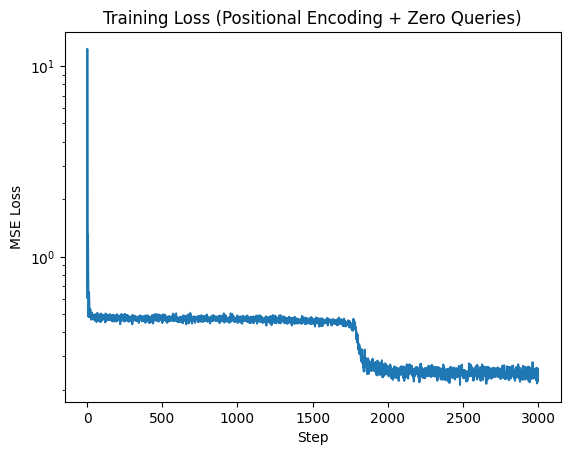

In [15]:
# Plot training curve
plt.figure()
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.title("Training Loss (Positional Encoding + Zero Queries)")
plt.show()

In [17]:
model.eval()

# Generate test batch
x_test, y_test, taus = generate_periodic_batch(batch_size=10)
x_test = x_test.to(device)
y_test = y_test.to(device)

# Prepare inputs
y_in = torch.zeros_like(y_test)

# Forward pass through encoder only (to get memory)
with torch.no_grad():
    src = model.in_proj(x_test)
    src = model.pos_enc(src)
    mem = model.encoder(src)

    # Decoder input embeddings
    tgt = model.in_proj(y_in)
    tgt = model.pos_enc(tgt)

    # Access the first decoder layer
    layer = model.decoder.layers[0]

    # --- Self-attention on decoder side ---
    tgt2 = layer.self_attn(tgt, tgt, tgt, need_weights=False)[0]
    tgt = layer.norm1(tgt + layer.dropout1(tgt2))

    # --- Cross-attention: queries from tgt, keys/values from mem ---
    tgt2, attn = layer.multihead_attn(
        tgt, mem, mem,
        need_weights=True,
        average_attn_weights=False
    )

print("Cross-attention weights shape:", attn.shape)  
# Typically (B, T_dec, T_enc)

Cross-attention weights shape: torch.Size([10, 1, 1000, 1000])


In [18]:
taus

tensor([ 20, 220, 220,  20,  20,  20,  20,  20,  20,  20])

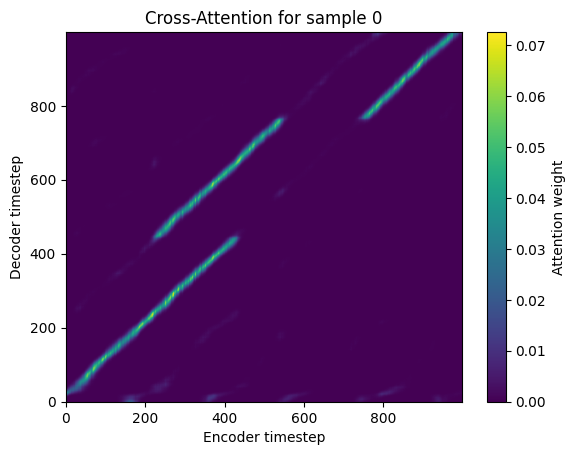

In [22]:
i = 0  # pick a sample index
attn_i = attn[i][0].detach().cpu()  # (T_dec, T_enc)
plt.imshow(attn_i, aspect='auto', origin='lower')
plt.colorbar(label='Attention weight')
plt.xlabel('Encoder timestep')
plt.ylabel('Decoder timestep')
plt.title(f'Cross-Attention for sample {i}')
plt.show()

In [24]:
import numpy as np

# attn_per_example: (B, T_dec, T_enc)  (after averaging across heads)
i = 0  # pick example
attn_map = attn_per_example[i]  # (T_dec, T_enc)

# Extract ridge by argmax across encoder axis
ridge = attn_map.argmax(dim=1).cpu().numpy()  # (T_dec,)

plt.figure(figsize=(8,6))
plt.imshow(attn_map.cpu(), aspect='auto', origin='lower', cmap='viridis')
plt.plot(ridge, np.arange(len(ridge)), 'r', linewidth=1.5, label='ridge')
plt.xlabel('Encoder timestep')
plt.ylabel('Decoder timestep')
plt.title(f'Example {i}, τ={taus[i].item()}')
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'attn_per_example' is not defined

In [54]:
taus

tensor([220,  20,  20,  20, 220, 220, 220,  20,  20, 220])

In [53]:
np.mean(ridge)

np.float64(413.993)

In [55]:
delays = np.arange(len(ridge)) - ridge
avg_delay = delays.mean()
print("Estimated lag:", avg_delay, " True lag:", taus[i].item())

Estimated lag: 85.507  True lag: 220


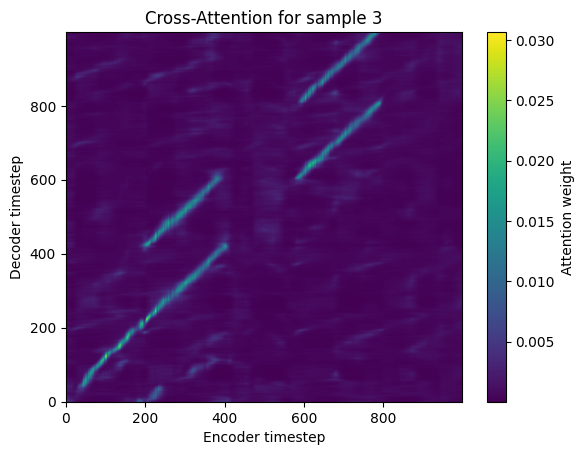

In [47]:
attn_per_example = attn.mean(dim=1)  # shape: (B, T_dec, T_enc)
i = 3  # pick a sample index
attn_i = attn_per_example[i].detach().cpu()  # (T_dec, T_enc)
plt.imshow(attn_i, aspect='auto', origin='lower')
plt.colorbar(label='Attention weight')
plt.xlabel('Encoder timestep')
plt.ylabel('Decoder timestep')
plt.title(f'Cross-Attention for sample {i}')
plt.show()

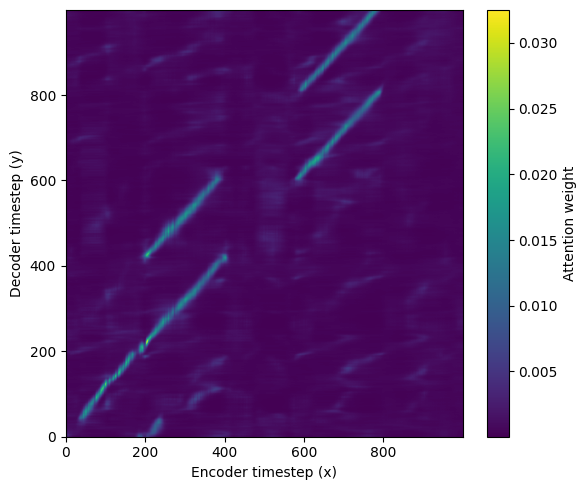

In [35]:
attn_map = attn[2].detach().cpu().numpy()
plt.figure(figsize=(6, 5))
plt.imshow(attn_map, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Attention weight')
plt.xlabel('Encoder timestep (x)')
plt.ylabel('Decoder timestep (y)')
#plt.title(f'Cross-Attention Map (τ={tau}) — Positional Encoding + Zero Queries')
plt.tight_layout()
plt.show()

In [25]:
taus

tensor([ 20, 220,  20, 220])

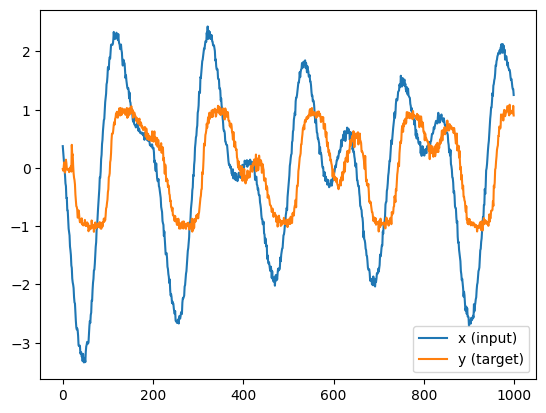

In [25]:
# Optional: visualize input/output
plt.figure()
plt.plot(x_test[0].cpu().numpy(), label='x (input)')
plt.plot(y_test[0].cpu().numpy(), label='y (target)')
plt.legend()
#plt.title("Example Sine Wave with Lag")
plt.show()

In [27]:
# attn: (B, T_dec, T_enc)
# lags: (B,) ground truth from generator

# Find ridge per decoder timestep
ridge_x = attn.argmax(dim=2)   # (B, T_dec)

t_dec = attn.size(1)

# 🔥 Corrected delay definition: τ = decoder step - encoder step
delays = torch.arange(t_dec, device=attn.device).unsqueeze(0) - ridge_x  # (B, T_dec)

# Average delay per example
avg_delays = delays.float().mean(dim=1)   # (B,)

/scratch/780091.1.v100/ipykernel_3597506/4293583299.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


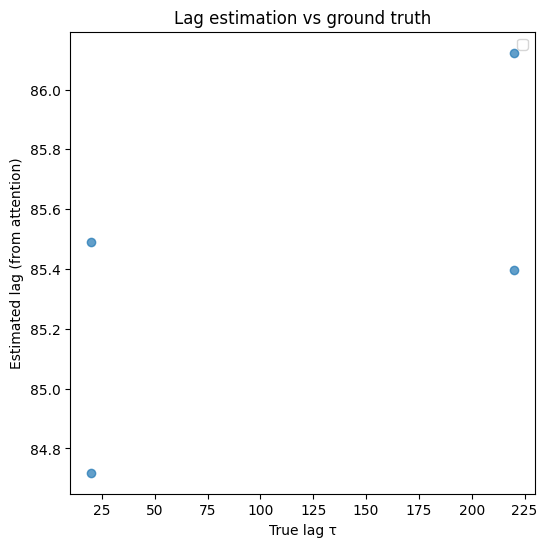

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(taus.cpu(), avg_delays.cpu(), alpha=0.7)
#plt.plot([lags.min(), lags.max()], [lags.min(), lags.max()], 'r--', label="Perfect match")

plt.xlabel("True lag τ")
plt.ylabel("Estimated lag (from attention)")
plt.title("Lag estimation vs ground truth")
plt.legend()
plt.show()